# 1) Preliminares

**************************************
## 1.1) Entornos

Antes que nada es necesario importar las librerias de análisis de datos. Y es justo mencionarlo porque las librerias que uso son versiones específicas que pueden no funcionar al intentar correr el código en otro computador. Esto es usualmente manejado con el control de entornos (**env**) de python que prefiero hacerlo a través de **Anaconda**. Aún así, cuestiones del sistema operativo específico como las shared libraries pueden generar conflictos e impedir que el código corra, para lo cual se puede generar una **imagen** específica del sistema operativo y sus funcionalidades con **Docker**. En este caso dejo únicamente las especificaciones de las versiones de mis librerías en un archivo `.yml`.

## 1.2) Librerías

In [107]:
# librerías básicas
from datetime import datetime, timedelta, date
import decimal as decimal
import time
import sys
from collections import Counter

# Librerías para análisis básico
import numpy as np
import pandas as pd
import pandas_profiling
import json 

# Librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt

# Librerías para análisis avanzado de datos
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, SCORERS, f1_score, roc_auc_score, accuracy_score, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

# Encoders
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.one_hot import OneHotEncoder

# 3) Cargando los datos
Se asume que los archivos están en la ubicación `../Data/` relativo a la carpeta desde donde se corre el notebook de python.

En una primera versión del análisis se usará la versión simplificada del problema sin el archivo de créditos de las películas. El archivo que se usa se asume con nombre:
`tmdb_5000_movies.csv`

In [108]:
folder = '../Data/'
data = pd.read_csv(folder+'tmdb_5000_movies.csv')
print(data.info())

# Eliminamos nulos porque no hay suficiente información para hacer un correcto tratamiento
data.dropna(subset=['release_date'], inplace= True)
data.dropna(subset=['runtime'], inplace= True)

# Primeros valore para explorar
data.head(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null 

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


# 4) Tratamiento de datos
## 4.1) Obtención de la información en los JSONs
Al revisar los primeros campos, es sencillo ver que la tabla no está correctamente formateada para hacer un análisis sencillo o rápido. Entonces, es necesario minar data que puede ser considerada útil.

Primero empezamos por eliminar información irrelevante de la lista de JSONs o diccionarios.

In [109]:
# A partir de la lista de JSONs obtiene una lista de sólo géneros sin los ids
data['genres'] = data['genres'].map(lambda x: [y['name'] for y in json.loads(x)])
data['genres']

0       [Action, Adventure, Fantasy, Science Fiction]
1                        [Adventure, Fantasy, Action]
2                          [Action, Adventure, Crime]
3                    [Action, Crime, Drama, Thriller]
4                [Action, Adventure, Science Fiction]
                            ...                      
4798                        [Action, Crime, Thriller]
4799                                [Comedy, Romance]
4800               [Comedy, Drama, Romance, TV Movie]
4801                                               []
4802                                    [Documentary]
Name: genres, Length: 4800, dtype: object

In [110]:
# Se realiza lo mismo para las demás columnas
data['keywords'] = data['keywords'].map(lambda x: [y['name'] for y in json.loads(x)])
data['production_companies'] = data['production_companies'].map(lambda x: [y['name'] for y in json.loads(x)])
data['production_countries'] = data['production_countries'].map(lambda x: [y['iso_3166_1'] for y in json.loads(x)])
data['spoken_languages'] = data['spoken_languages'].map(lambda x: [y['iso_639_1'] for y in json.loads(x)])

In [111]:
data.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[US, GB]",2009-12-10,2787965087,162.0,"[en, es]",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[US],2007-05-19,961000000,169.0,[en],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


----------------------------------
Una vez pasado todo a listas, es mucho más sencillo trabajar con los datos. Ahora, como queremos predecir el éxito de una película, nos restringiremos a variables importantes y dicientes

In [112]:
# Seleccionamos variables importantes y descartamos las otras ya que requerirían procesos más sofisticado de minería
data = data[[ 'id','original_title' # identifiers
             ,'release_date' # Para poder filtrar
             ,'vote_average' # Para poder predecir esta variable en un futuro como éxito de la película
             ,'budget' # Según la información de la página, el budget no es claro si está en moneda unificada
             ,'genres'
             ,'keywords'
             ,'original_language'
             ,'production_companies'
             ,'production_countries'
             ,'spoken_languages'
             ,'runtime']]

# El índice será el id
data.set_index('id',inplace = True)

# Se define el target a predecir 
target = 'vote_average'

#################################################
### Features interesantes y fáciles de sacar ####
#################################################

# Cast de fecha
data['release_date'] = data['release_date'].map(lambda x: datetime.strptime(str(x), "%Y-%m-%d").date())

# Sería interesante saber si el mes en el que se lanza la película tiene que ver con su éxito
data['month_released'] = data['release_date'].map(lambda x: x.month)

# Se pone el original language en el idioma de las demás categorías
data['original_language'] = data['original_language'].map(lambda x: [x])

# Antes de proseguir, sería interesante saber si el numero de elementos de la lista tienen que ver con 
# el exito de las peliculas (cuantos generos, cuantos keywords, cuantos paises, cuantos companias, cuantos lenguages)
data['count_genres'] = data['genres'].map(len)
data['count_keywords'] = data['keywords'].map(len)
data['count_production_companies'] = data['production_companies'].map(len)
data['count_production_countries'] = data['production_countries'].map(len)
data['count_spoken_languages'] = data['spoken_languages'].map(len)
# Además eliminamos el lenguaje original de la categoría spoken languages para que no haya redundancia
# Sólo quedarán los spoken languages diferentes al original
data['spoken_languages'] = data['spoken_languages'].map(lambda x: set(x))-data['original_language'].map(lambda x: set(x))
data['spoken_languages'] = data['spoken_languages'].map(lambda x: list(x))

# Rellenamos vacíos en caso de que la película no tenga ningún valor en la columna
data['spoken_languages'] = data['spoken_languages'].map(lambda x: ['sin extra'] if x == [] else x)
data['production_companies'] = data['production_companies'].map(lambda x: ['sin companies'] if x == [] else x)
data['production_countries'] = data['production_countries'].map(lambda x: ['sin country'] if x == [] else x)
data['keywords'] = data['keywords'].map(lambda x: ['sin keyword'] if x == [] else x)
data['genres'] = data['genres'].map(lambda x: ['sin genre'] if x == [] else x)

In [113]:
data[['spoken_languages','original_language']]

,spoken_languages,original_language
id,,
19995,[es],[en]
285,[sin extra],[en]
206647,"[de, es, it, fr]",[en]
49026,[sin extra],[en]
49529,[sin extra],[en]
...,...,...
9367,[sin extra],[es]
72766,[sin extra],[en]
231617,[sin extra],[en]


In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 19995 to 25975
Data columns (total 17 columns):
original_title                4800 non-null object
release_date                  4800 non-null object
vote_average                  4800 non-null float64
budget                        4800 non-null int64
genres                        4800 non-null object
keywords                      4800 non-null object
original_language             4800 non-null object
production_companies          4800 non-null object
production_countries          4800 non-null object
spoken_languages              4800 non-null object
runtime                       4800 non-null float64
month_released                4800 non-null int64
count_genres                  4800 non-null int64
count_keywords                4800 non-null int64
count_production_companies    4800 non-null int64
count_production_countries    4800 non-null int64
count_spoken_languages        4800 non-null int64
dtypes: float64(2), int64(

## 4.2) Codificación de categorías

-----------------------
El problema más grande de este set de datos es la codificación de variables categóricas de alta cardinalidad ya queun one-hot encoding no es rentable en términos computacionales, menos aún si hay tan pocos datos (terminaríamos con más columnas que registros). La matriz de features que arrojaría tendría demasiados ceros, lo cual significa que cada una de las muchas columnas aportaría muy poca información. Para hacerse cargo de este problema no hay solución sencilla. Cualquier solución de aquí en adelante para la codificación de las variables categóricas sacrifica fuertemente la interpretabilidad del modelo de predicción.

El método escogido aquí será un Target encoder, el cual le asigna el valor promedio de la variable target a cada categoría de la variable categórica y de esa manera la transforma en numérica. Esto puede parecer trampa y es una técnica que si no se hace con las precauciones necesarias, puede resultar en un target leakage artificial. Sin embargo, esta técnica está muy bien documentada y se puede tomar la precaución de sólo realizar la codificación para el set de datos de TRAIN y de ahí deducir el las asignaciones numéricas para aplicar al TEST. Se puede ir un poco más allá y exigir temporalidad en la partición de TRAIN y test. De esta manera, el target encoder funciona como una memoria de performance pasado de ciertas categorías como *production companies*.

El primer paso en el tratamiento de variables categóricas es vectorizarlas.

In [115]:
# Obtiene todos los valores y los respectivos conteos de una columna
# Si la categoría tiene 1 de frecuencia, es colapsada en una categoría llamada 'Otros'
def get_all_values(col):
    # La lista de valores
    list_vals = []
    # recorre todos los registros obteniendo los respectivos valores
    for i in range(len(col.index)):
        list_vals = list_vals + col.iloc[i]
    
    # Realiza el conteo de variables
    counter = Counter(list_vals)
    distinct_vals = list(counter.keys())
    count_vals = np.array(list(counter.values()))
    # Indices del orden descendiente de frecuencia
    arg_sort = np.argsort(-1*count_vals)
    # Ordena
    distinct_vals = list(np.array(distinct_vals)[arg_sort])
    count_vals = count_vals[arg_sort]
    # Retorna los valores unicos, los conteos y la lista de valores de donde se sacó la información
    return distinct_vals,count_vals,list_vals

------------------------------------------
Esta funcion nos servirá para más adelante, pero por ahora es interesante ver cuáles son los valores más frecuentes de cada variable categórica

++++++++++++++++++++++ Category original_language +++++++++++++++++++++++++
Esta categoría tiene 37 valores distintos
++++++++++++++++++++++ Category production_countries +++++++++++++++++++++++++
Esta categoría tiene 89 valores distintos
++++++++++++++++++++++ Category spoken_languages +++++++++++++++++++++++++
Esta categoría tiene 84 valores distintos
++++++++++++++++++++++ Category genres +++++++++++++++++++++++++
Esta categoría tiene 21 valores distintos
++++++++++++++++++++++ Category keywords +++++++++++++++++++++++++
Esta categoría tiene 9809 valores distintos
++++++++++++++++++++++ Category production_companies +++++++++++++++++++++++++
Esta categoría tiene 5016 valores distintos


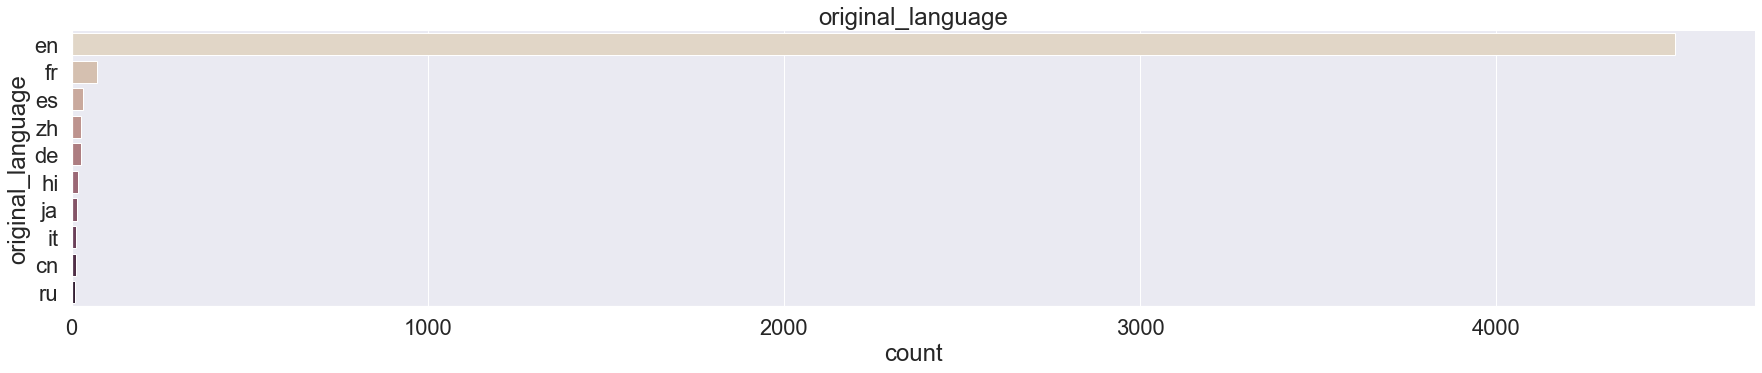

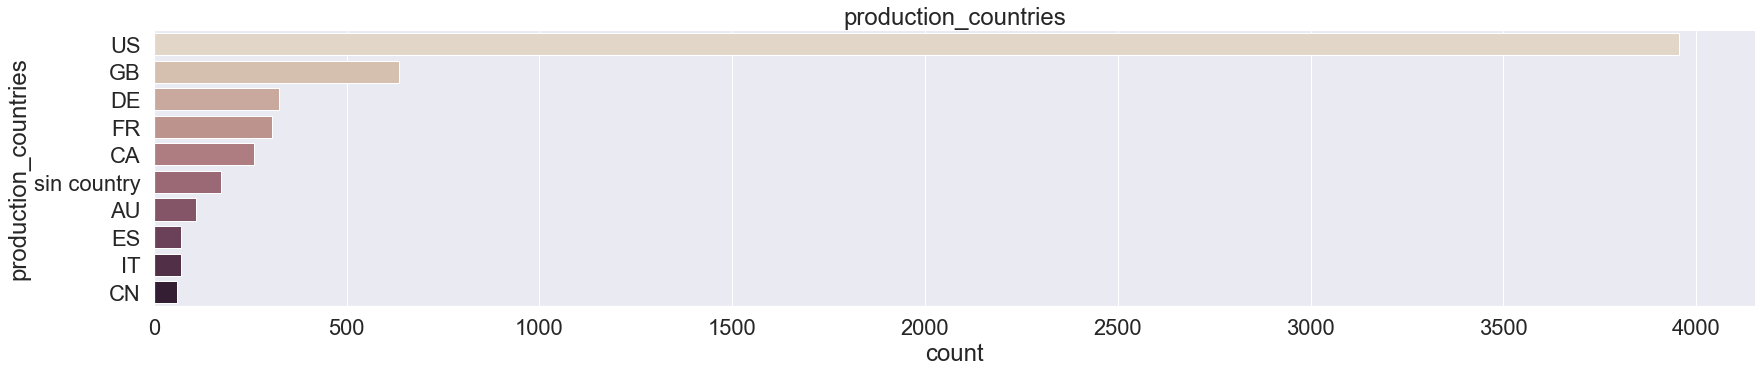

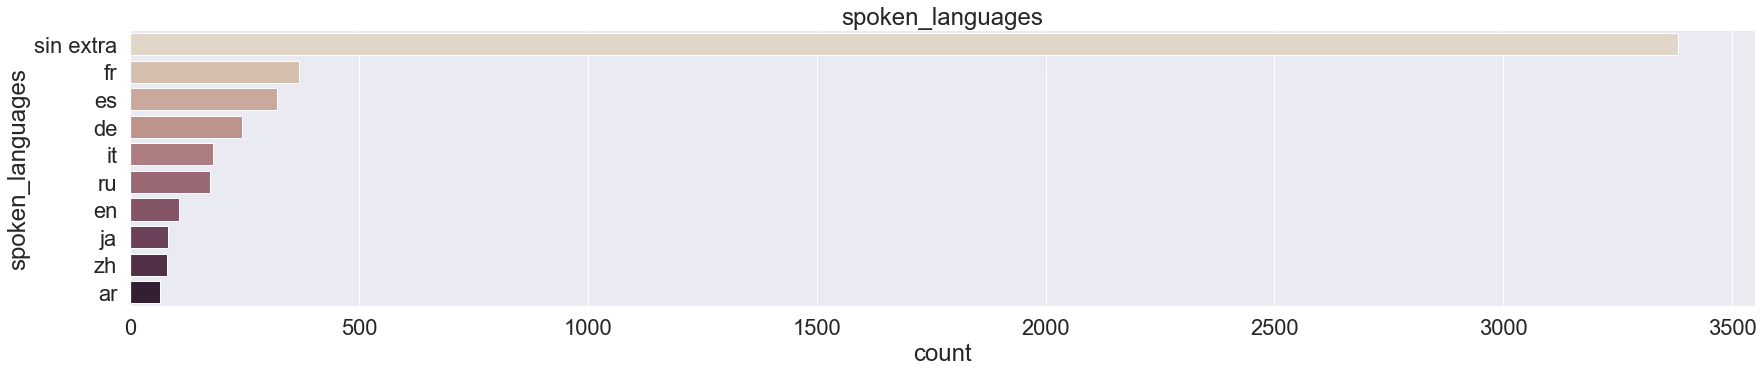

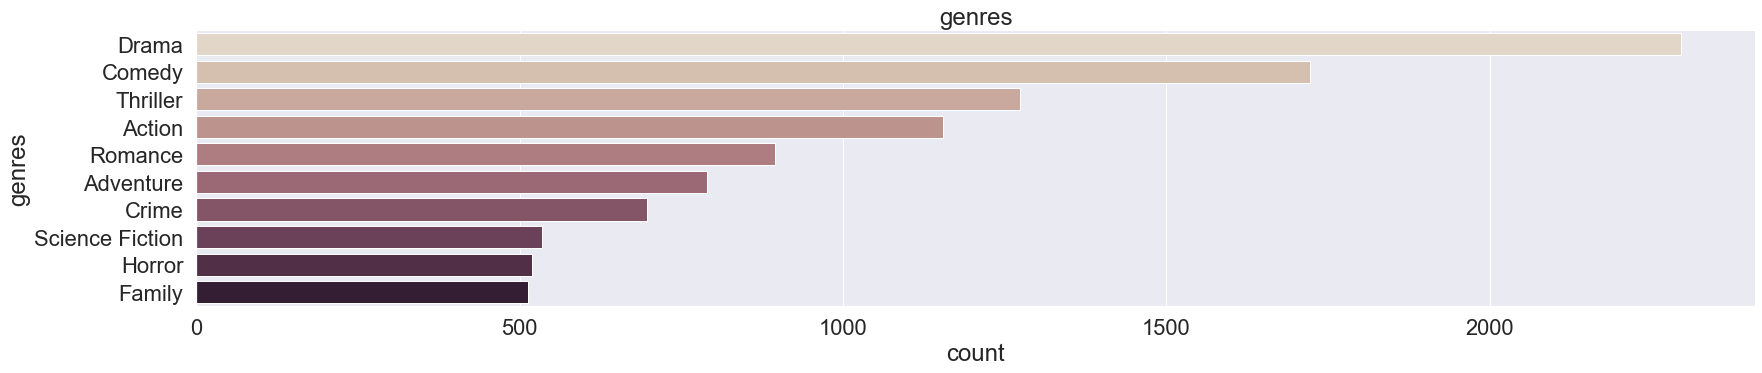

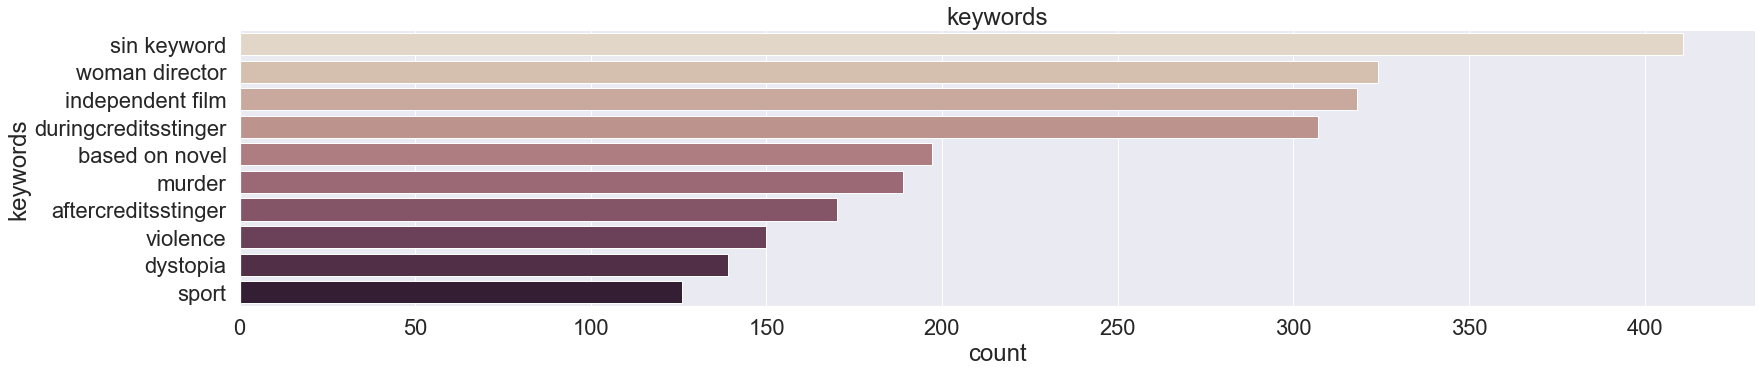

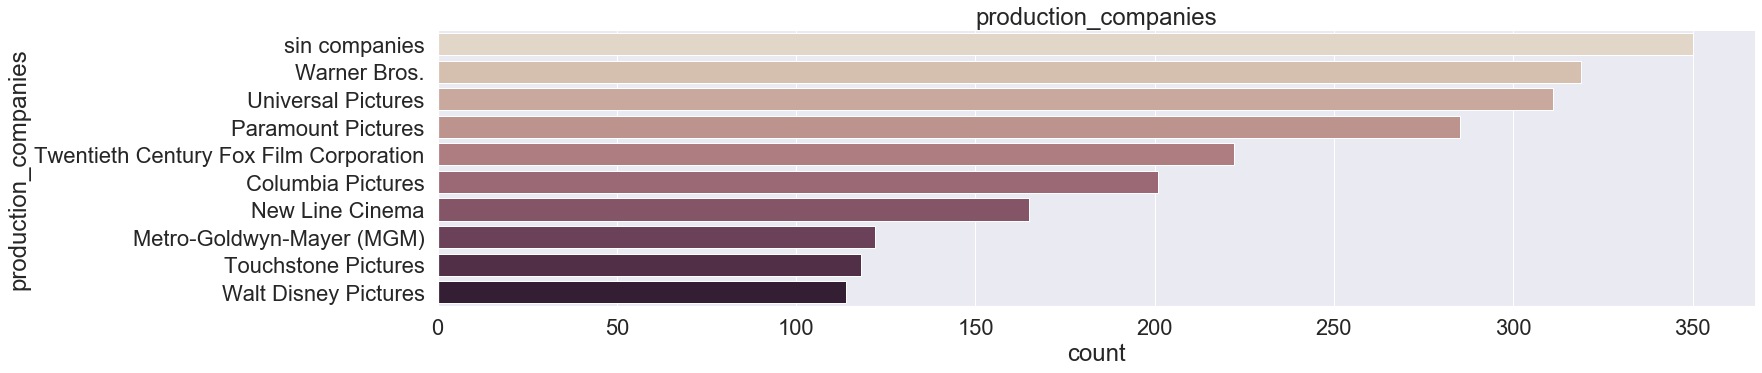

In [116]:
# Fuentes más grandes
sns.set(font_scale=2) 
for cate in ['original_language','production_countries','spoken_languages','genres','keywords','production_companies']:
    print('++++++++++++++++++++++ Category %s +++++++++++++++++++++++++'%cate)
    distinct_vals,count_vals,total_vals = get_all_values(data[cate])
    print('Esta categoría tiene %d valores distintos'%len(distinct_vals))
    # Para graficar
    to_graph = pd.DataFrame(total_vals,columns=[cate])
    best_10 = distinct_vals[:10]
    sns.catplot( y=cate
                ,data = to_graph[to_graph[cate].isin(best_10)] 
                ,kind="count"
                ,aspect = 5
                ,palette="ch:.25"
                ,order = best_10)
    plt.title(cate)
   

In [204]:
# Ahora se define la función para codificar las categorías
def target_encoder(d_fit,d_train):
    # en caso de que hayan pocos datos para calcular un average
    avg_ = d_train[target].mean()
    for cate in ['original_language','production_countries','spoken_languages','genres','keywords','production_companies']:
        print('-------------'+cate)
        d_fit['COD_'+cate] = 0
        m = 0
        # Recorre el arreglo llenando los valores de acuerdo al target
        for ID in (d_fit.index):
            #if m%1000 == 0:
            #    print(m)
            # Tenemos la observación iésima de la categoría cate
            cat_vals = d_fit.loc[ID,cate]
            avg = 0
            # los datos que contienen alguna de estas categorias en el train
            mask = d_train[cate].map(lambda x: any([val in x for val in cat_vals]))
            # Si se encontraron menos de 3 observaciones con esta categoría, se añade el promedio general
            if len(d_train[mask].index) <= 100:
                avg = avg_
            else:
                avg = d_train.loc[mask,target].mean()
            d_fit.loc[ID,'COD_'+cate] = avg
            m+=1
    # Elimina las variables antiguas
    #d_fit.drop(['original_language','production_countries','spoken_languages','genres','keywords','production_companies'], axis=1)
    return d_fit

# 5) Ajuste de modelo de predicción
Una vez hecha toda la codificación, se puede proceder a entrenar el modelo de machine learning para poder predecir el éxito de una película. En este caso me he decidido únicamente por modelos a base de árboles de dedecisión, los cuales se basan en cortes de percentiles para separar poblaciones con diferente target. Dado que los percentiles son invariantes bajo transformaciones de escala y traslaciones, o bajo cualquier transformación monotónica, no se realizó ningún tratamiento de las variables numéricas.

## 5.1) Train-Test split
El primer paso es partir las bases en train y test. Esto se puede hacer de muchas maneras. En este caso elijo partirlas 80%-20% de acuerdo a un ordenamiento por fecha. Esto es para demostrar que el target encoding no genera target leakage.

In [205]:
# Se generan percentiles ordenados por fecha 
data['PERCENTILE'] = pd.qcut(data.release_date, 10, labels=range(1,11))
# Se escoge la base de train
d_train = data[data['PERCENTILE'] <= 8]
# Se escoge la base de test
d_test = data[data['PERCENTILE'] > 8]

# se realiza la codificación de las variables
d_train = target_encoder(d_train,d_train) # LA base de train se codifica con ella misma
d_test = target_encoder(d_test,d_train)


-------------original_language


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


-------------production_countries
-------------spoken_languages
-------------genres
-------------keywords
-------------production_companies
-------------original_language
-------------production_countries
-------------spoken_languages
-------------genres
-------------keywords
-------------production_companies


In [206]:
# Se separa la variable target y las features

features = [ 'COD_original_language'
             ,'COD_production_countries'
             ,'COD_spoken_languages'
             ,'COD_genres'
             ,'COD_keywords'
             ,'COD_production_companies'
             ,'budget'
             ,'runtime'
             ,'month_released'
             ,'count_genres'
             ,'count_keywords'
             ,'count_production_companies'
             ,'count_production_countries'
             ,'count_spoken_languages']
X_test = d_test[features]
y_test = d_test[target]
X_train = d_train[features]
y_train = d_train[target]

## 5.2) Target binario
Para poder decir si una pelicula tuvo exito o no a partir de una variable continua como la calificación, es necesario volver la variable binaria definiendo un threshold. Ese threshold será elegido a partir de la distribución del target.

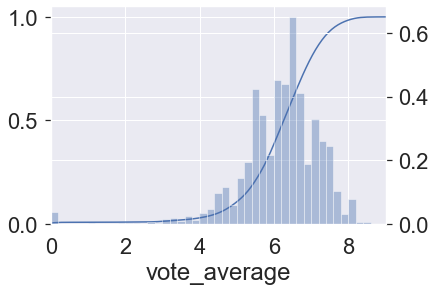

In [207]:
x = y_train
kwargs = {'cumulative': True}
ax = sns.distplot(x,hist = False,norm_hist=True,kde_kws=kwargs)
ax2 = plt.twinx()
sns.distplot(x,hist = True,norm_hist=True,kde=False,ax = ax2)
plt.xlim(0,9)

# Se transforman las features a float32 (menos pesado computacionalmente)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

### Se define el threshold del target como 7.0

In [208]:
# Se transforma el target a binario
y_test = (y_test >= 7).astype(np.int32)
y_train = (y_train >= 7).astype(np.int32)

## 5.3) El modelo

In [246]:
# Para escoger hiperparámetros óptimos con gridsearchCV aleatorizado
'''
# Se inicializa el modelo
mod = GradientBoostingClassifier()

# Los hiperparámetros
hyper_params =  {'loss': ['deviance', 'exponential'],
                 'learning_rate': [0.1,0.2,0.4,0.8,1.6],
                 'max_depth': [15,20,25],
                 'max_features': ['auto', 'sqrt', 'log2', None],
                 'min_samples_leaf': [1, 2, 4, 8],
                 'min_samples_split': [10,20,30],
                 'n_estimators': [30,50,100,150]} 
# Se inicializa la grilla de parámetros para buscar
mod_random = RandomizedSearchCV( estimator = mod
                                ,param_distributions = hyper_params
                                ,n_iter = 200
                                ,cv = 3
                                ,verbose = 10
                                ,n_jobs = -1)
# Se realiza la búsqueda de parámetros
mod_random.fit(X_train,y_train)
'''



# Los mejores parámetros son:
# Por experiencia propia, para datasets con pocos datos, estos son 
# los parametros que mejor se comportan
best_params = {'n_estimators': 50,
               'min_samples_split': 4,
               'min_samples_leaf': 3,
               'max_features': 'log2',
               'max_depth': 3,
               'loss': 'deviance',
               'learning_rate': 0.1}
# Parametros adicionales no son hiperparámetros del modelo
best_params['verbose'] = 0
best_params['random_state'] = 2305

# Se inicializa el modelo con los mejores hiperparámetros
mod = GradientBoostingClassifier(**best_params)
# Se entrena el modelo con la data de entrenamiento
mod.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=4,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=2305, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# 6) Reporte de resultados
Ahora, tenemos que verificar que el modelo en realidad funciona bien, para eso, se verifican varias métricas estándares de performance. En total se mirará:

* La curva ROC
* El area debajo de la curva ROC (AUC: Area Under the Curve)
* El F1 score máximo (es necesario maximizar el threshold)
* El Balanced Accuracy score

In [252]:
# Genera el reporte de performance de acuerdo a los puntos definidos anteriormente
# Input: X: las variables predictivas, y: la variable target, model: el modelo entrenado
def performance_report(X,y,model):
    # primero se obtiene la predicción
    # Se obtiene la probabilidad en lugar de la clasificación final porque tiene más información y es más versátil
    y_model = model.predict_proba(X)[:,1] # La probabilidad de la clase '1' (casualmente el índice 1 en la lista [0,1])
    
    ##############################################################
    ################ MAXIMIZACION DEL F1 SCORE ###################
    ##############################################################
    thresholds = []
    # Recorre el espacio de thresholds (para en 0.4) dado el desbalanceo del target (~20%)
    for thresh in np.arange(0.1, 0.401, 0.001):
        # Calcula el f1 en el threshold actual
        res = f1_score(y, (y_model > thresh).astype(int))
        # añade los resultados a la lista
        thresholds.append([thresh, res])
    # Ordena los resultados de mayor F1 a menor F1
    thresholds.sort(key=lambda x: x[1], reverse=True)
    best_thresh =  np.round(thresholds[0][0], 3)
    print('-----------------------------------------------------------------')
    print('El trheshold que maximiza el F1 score es: ', best_thresh)
    print('-----------------------------------------------------------------')
    # La prediccion en términos de clases
    y_pred_class = (y_model > thresh).astype(int)
    
    ##############################################################
    ################ AREA UNDER THE (ROC) CURVE ##################
    ##############################################################
    # Tasa de falsos positivos (false positive rate) y tasa de verdaderos positivos (true positive rate)
    fpr, tpr, thresholds = roc_curve(y, y_model)
    auc_val = auc(fpr, tpr)
    print('-----------------------------------------------------------------')
    print('El valor de AUC es: ', auc_val)
    print('-----------------------------------------------------------------')

    ##############################################################
    ################### BALANCED_ACCURACY ########################
    ############################################################## 

    bas = balanced_accuracy_score(y, y_pred_class)
    print('-----------------------------------------------------------------')
    print('El valor del Balanced Accuracy es: ', bas)
    print('-----------------------------------------------------------------')
    
    ##############################################################
    ############## REPORTE DE CLASIFICACION ######################
    ############################################################## 
    print('-----------------------------------------------------------------')
    print('-----------------------------------------------------------------')
    print(classification_report(y, y_pred_class))
    print('-----------------------------------------------------------------')
    print('-----------------------------------------------------------------')
    
    
    # Crea la figura
    fig = plt.figure(figsize=(12,8))
    #plt.gcf().add_subplot()
    
    # Define los ejes
    ax1 = plt.subplot(221)
    ax3 = plt.subplot(212)
    ax2 = plt.subplot(222)

    ##############################################################
    ################### GRAFICA LA ROC ###########################
    ############################################################## 
    # Compute ROC curve and area the curve
    ax1.plot(fpr, tpr, lw=1, alpha=0.3,label='(AUC = %0.3f)'%auc_val)
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    ax1.set_xlim([-0.05, 1.05]) #plt.xlim
    ax1.set_ylim([-0.05, 1.05]) 
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC curve ')
    ax1.legend(loc='best')

    ##############################################################
    # MATRIZ DE CONFUSION ( con el threshold que maximiza el f1) #
    ############################################################## 
    labels = [1, 0]
    cm = confusion_matrix(y, y_pred_class, labels)
    print(cm)
    cax = ax2.matshow(np.log(cm))
    fig.colorbar(cax)
    ax2.set_xticklabels([''] + labels)
    ax2.set_yticklabels([''] + labels)
    ax2.set_xlabel('Actual Class')
    ax2.set_ylabel('Predicted Class')

    ##############################################################
    ################ GRAFICA EL LIFT CHART #######################
    ############################################################## 
    df_dict = {'actual': list (y), 'pred': list(y_model)}
    df = pd.DataFrame(df_dict)
    pred_ranks = pd.qcut(df['pred'].rank(method='first'), 10, labels=False)
    actual_ranks = pd.qcut(df['actual'].rank(method='first'), 10, labels=False)
    pred_percentiles = df.groupby(pred_ranks).mean()
    actual_percentiles = df.groupby(actual_ranks).mean()
    ax3.set_title('Lift Chart')
    ax3.plot(np.arange(.1, 1.1, .1), np.array(pred_percentiles['pred']),
             color='darkorange', lw=2, label='Prediction')
    ax3.plot(np.arange(.1, 1.1, .1), np.array(pred_percentiles['actual']),
             color='navy', lw=2, linestyle='--', label='Actual')
    ax3.set_ylabel('Target Average')
    ax3.set_xlabel('Population Percentile')
    ax3.set_xlim([0.0, 1.1])
    ax3.set_ylim([0,0.05+max([max(np.array(pred_percentiles['pred'])),max(np.array(pred_percentiles['actual']))])])
    ax3.legend(loc="best")
    
    fig.tight_layout()

----------------------------------------------------------------------------------------------------------------------------------
TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST
TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST
TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST
----------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------
El trheshold que maximiza el F1 score es:  0.259
-----------------------------------------------------------------
-----------------------------------------------------------------
El valor de AUC es:  0.7537206343570626
----------------------------------------------------------

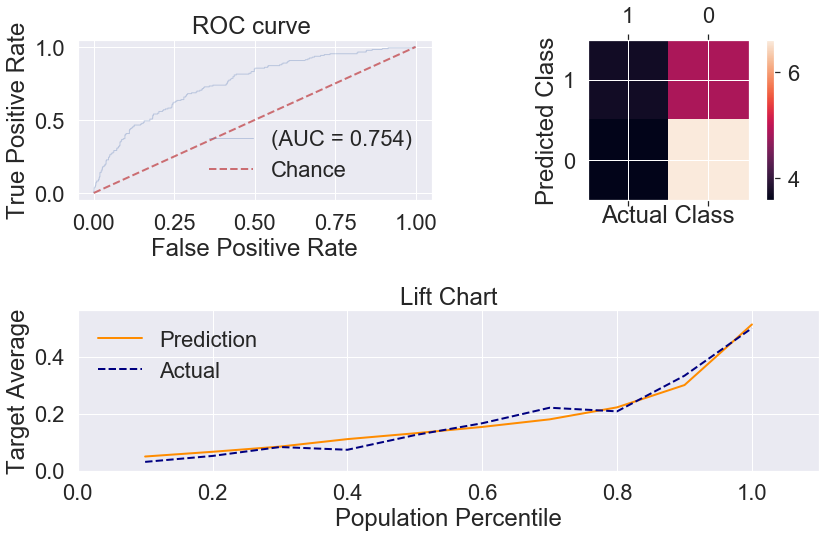

In [253]:

print('----------------------------------------------------------------------------------------------------------------------------------')
print('TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST')
print('TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST')
print('TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST--TEST')
print('----------------------------------------------------------------------------------------------------------------------------------')
performance_report(X_test,y_test,mod)

----------------------------------------------------------------------------------------------------------------------------------
TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAI
TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAI
TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAI
----------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------
El trheshold que maximiza el F1 score es:  0.29
-----------------------------------------------------------------
-----------------------------------------------------------------
El valor de AUC es:  0.8388618993475894
-----------------------------------------------------------

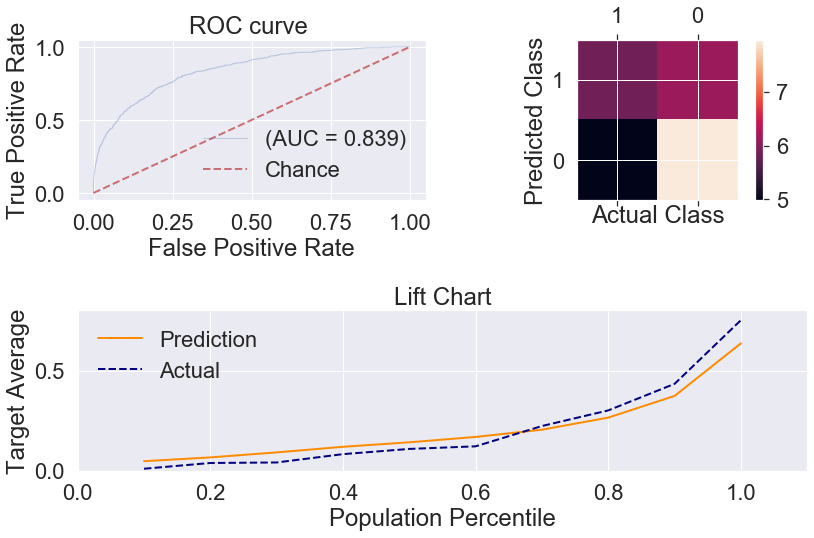

In [254]:
# Ahora se genera el reporte para la base de test y la base de train
print('----------------------------------------------------------------------------------------------------------------------------------')
print('TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAI')
print('TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAI')
print('TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAIN--TRAI')
print('----------------------------------------------------------------------------------------------------------------------------------')
performance_report(X_train,y_train,mod)

## Best columns

In [ ]:
# Ordena las columnas de menor a mayor importancia
arg_s = (-mod.feature_importances_).argsort()
best_cols = pd.DataFrame(zip(X_train.columns[arg_s],mod.feature_importances_[arg_s]),columns = ['COLUMNA','IMPORTANCIA'])
print(best_cols)

In [ ]:
sns.jointplot(x=X_train['COD_original_language'],y=d_train[target],kind="reg",logistic=True)
